In [206]:
import pandas as pd
import numpy as np
# import warnings
# warnings.filterwarnings("ignore")

## Config

In [207]:
# To Fix
train_filter_mode = 0 # 0: include, 1: exclude 
test_filter_mode = 0
train_target_cell = ["RPE1"]
test_target_cell = ["RPE1"]
neg_sam_ratio = 1 # N: 1:N
same_dataset = True # Use the same dataset to train, validation and test. (70 : 15 : 15) Otherwise, Use train set to train; use test set to validation and test (50: 50)
weight_decay = 0.001

## Read Data

In [208]:
def parse_text_file(file_path):
    data_dict = {}
    with open(file_path, 'r') as file:
        for line in file:
            # Remove leading/trailing whitespace and split by spaces
            elements = line.strip().split()
            
            # Skip empty lines
            if not elements:
                continue
                
            # Extract key (first element) and features (remaining elements)
            key = int(elements[0])
            # if key not in ncbi_to_scgpt:
            #     continue
            # key = ncbi_to_scgpt[key]
            features = list(map(float, elements[1:]))  # Convert to floats
            
            data_dict[key] = features
    return data_dict

In [209]:
import pickle

# Outside Embeddings
with open('./data/scgpt_emb.pkl', 'rb') as f:
    scgpt_emb = pickle.load(f)
with open('./data/geneformer_gene_embs.pkl', 'rb') as f:
    geneformer_emb = pickle.load(f)
with open('../data/GenePT_emebdding_v2/GenePT_gene_embedding_ada_text.pickle', 'rb') as f:
    genept_emb = pickle.load(f)
with open("./data/kg_embeddings_64.pkl","rb") as f:
    kg_info = pickle.load(f)
with open("./data/protein_emb.pkl", "rb") as f:
    protein_emb = pickle.load(f)
ppi_emb = parse_text_file('./data/ppi_emb.txt')


# Protein info: find ncbi index -> scgpt index
protein_info = pd.read_csv('./data/protein_info.csv')

# Gene Expression
gene_expression = pd.read_csv(
    './data/CCLE_normalized_expression.txt',    # 文件名
    sep='\s+',     # 匹配任意空白字符作为分隔符
    header=0,      # 使用第一行作为列名
    index_col=0,   # 使用第一列作为行索引
    engine='python' # 确保处理不规则空格
)

# maps
scgpt_gene2idx = pd.read_csv('./data/scgpt_gene2idx.txt', sep='\t', header=None)
dbid2name = pd.read_csv('./data/dbid2name.csv')['name'].to_dict()


# SL data
# sl_train = pd.read_csv('./data/sl_train.csv')
sl_raw = pd.read_csv('../data/SLKB_rawSL.csv')

In [210]:
print(gene_expression)

            CORL24      HSC3     KMS11    C2BBE1   CORL311     HCC33  \
gene_ids                                                               
A1BG      2.849391 -0.808122 -0.407499  0.324076  0.232819  2.182273   
A1CF     -0.224682 -2.365709 -0.920761  4.670182 -1.548158 -1.542082   
A2M      -5.040961 -5.817617 -4.175663 -2.158997 -3.050761 -3.549381   
A2ML1    -2.014530 -2.013579 -1.871127 -2.063357 -1.202725 -0.811257   
A3GALT2  -2.023289 -5.817617 -5.817617 -5.029529 -3.707306 -2.841032   
...            ...       ...       ...       ...       ...       ...   
ZYG11A    3.454790  2.938309  5.636054  2.353795 -1.390345  1.153612   
ZYG11B    5.532251  4.766173  4.388785  5.133387  5.755072  5.549571   
ZYX       1.485196  6.646921  6.496448  8.212980 -2.068951 -1.149104   
ZZEF1     6.491424  6.010369  6.477038  5.676353  6.863211  6.265765   
ZZZ3      6.020686  6.354494  5.089011  4.809345  5.746466  6.352993   

              5637   CORL279     DMS53     JHOS2  ...   NCIH841

## Process Loaded Data

In [211]:
# map: gene name & scgpt id 
gene2idx_dict = dict(zip(scgpt_gene2idx[0], scgpt_gene2idx[1].astype(int)))
gene2name_dict = dict(zip(scgpt_gene2idx[1].astype(int), scgpt_gene2idx[0]))

# Protein info: name -> scgp id
gene_names = protein_info['Gene names'].str.split().apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else x)
mapped_ids = gene_names.map(gene2idx_dict)
protein_info['scGPT_id'] = mapped_ids.astype('Int64')
protein_info['scGPT_name'] = protein_info['scGPT_id'].map(gene2name_dict)

# map: NCBI id-> scgp id
ncbi_to_scgpt = dict(zip(protein_info['NCBI_gene_id'], protein_info['scGPT_id']))

# Geneformer: key: name -> scgpt id
origin_len = len(geneformer_emb)
geneformer_emb = {gene2idx_dict[k]:v  for k, v in geneformer_emb.items() if k in gene2idx_dict}

# GenePT: key: name -> scgpt id
origin_len = len(genept_emb)
genept_emb = {gene2idx_dict[k]:v  for k, v in genept_emb.items() if k in gene2idx_dict}

# PPI: key: NCBI id -> scgpt id
origin_len = len(ppi_emb)
ppi_emb = {ncbi_to_scgpt[k]:v  for k, v in ppi_emb.items() if k in ncbi_to_scgpt}

# KG: reindexed id -> dbid -> name -> scgpt id
kg_emb_list = kg_info['embeddings']
kg_id2entity = kg_info['id2entity']
kg_id_list = pd.DataFrame(range(len(kg_emb_list)), columns=['reindexed_id'])
kg_id_list['entity_id'] = kg_id_list['reindexed_id'].map(kg_id2entity).astype('Int64')
kg_id_list['name'] = kg_id_list['entity_id'].map(dbid2name)
kg_id_list['scgpt_id'] = kg_id_list['name'].map(gene2idx_dict).astype('Int64')
kg_emb = {id:kg_emb_list[i] for i, id in kg_id_list['scgpt_id'].dropna().items() }

# Gene Expression
gene_expression.index = gene_expression.index.map(gene2idx_dict).astype("Int64")



In [212]:
# SL
sl_raw.loc[sl_raw['SL_or_not']=='Not SL','label'] = 0
sl_raw.loc[sl_raw['SL_or_not']=='SL','label'] = 1
sl_raw['label'] = sl_raw['label'].astype('Int64')

sl_raw['geneA_scGPT_id'] = sl_raw['gene_1'].map(gene2idx_dict).astype('Int64')
sl_raw['geneB_scGPT_id'] = sl_raw['gene_2'].map(gene2idx_dict).astype('Int64')

# filter SL with included/excluded gene list
if train_filter_mode==0:
    sl_train = sl_raw[sl_raw['cell_line_origin'].isin(train_target_cell)]
elif train_filter_mode==1:
    sl_train = sl_raw[~sl_raw['cell_line_origin'].isin(train_target_cell)]

if not same_dataset:
    if train_filter_mode==0:
        sl_test = sl_raw[sl_raw['cell_line_origin'].isin(test_target_cell)]
    elif train_filter_mode==1:
        sl_test = sl_raw[~sl_raw['cell_line_origin'].isin(test_target_cell)]

sl_train = sl_train[['geneA_scGPT_id','geneB_scGPT_id', 'label', 'cell_line_origin']]
sl_train = sl_train.dropna()
if not same_dataset:
    sl_test = sl_test[['geneA_scGPT_id','geneB_scGPT_id', 'label', 'cell_line_origin']]
    sl_test = sl_test.dropna()
    


## Negative Sample

In [213]:
import pandas as pd
import numpy as np
import random

def reshape_neg_sample(df, ratio):
    """
    生成包含正负样本的合成致死数据集（按细胞系分组）
    
    参数:
    df -- 输入DataFrame，包含四列: gene_1, gene_2, Sl_or_not, cell_line_origin
    ratio -- 负样本与正样本的比例
    
    返回:
    包含正样本和负样本的DataFrame
    """
    # 复制原始数据避免修改原DataFrame
    df = df.copy()
    
    # 1. 提取所有正样本
    positive_df = df[df['label'] == 1].reset_index(drop=True)
    
    # 如果没有正样本，直接返回空DataFrame
    if positive_df.empty:
        return pd.DataFrame(columns=['geneA_scGPT_id', 'geneB_scGPT_id', 'label', 'cell_line_origin'])
    
    # 2. 按细胞系分组处理
    result_dfs = []
    
    # 获取所有细胞系
    cell_lines = df['cell_line_origin'].unique()
    
    for cell_line in cell_lines:
        # 获取当前细胞系的所有数据
        cell_line_df = df[df['cell_line_origin'] == cell_line]
        
        # 提取当前细胞系的正样本
        cell_positive_df = positive_df[positive_df['cell_line_origin'] == cell_line]
        
        # 如果当前细胞系没有正样本，跳过
        if cell_positive_df.empty:
            continue
        
        # 获取当前细胞系的所有基因
        genes_1 = cell_line_df['geneA_scGPT_id'].unique()
        genes_2 = cell_line_df['geneB_scGPT_id'].unique()
        all_genes = sorted(set(genes_1) | set(genes_2))
        
        # 获取当前细胞系所有已有的基因对
        existing_pairs = set()
        for _, row in cell_line_df.iterrows():
            gene1, gene2 = sorted([row['geneA_scGPT_id'], row['geneB_scGPT_id']])
            existing_pairs.add((gene1, gene2))
        
        # 计算当前细胞系需要生成的负样本数量
        n_positive = len(cell_positive_df)
        n_negative = int(n_positive * ratio)
        
        all_neg_pairs = [(i,j) for i in all_genes for j in all_genes if i!= j and (i,j) not in existing_pairs]
        
        # 生成负样本
        negative_pairs = random.sample(all_neg_pairs,n_negative)
        negative_samples = []
        
        for pair in negative_pairs:
            gene1, gene2 = pair
            negative_samples.append({
                'geneA_scGPT_id': gene1,
                'geneB_scGPT_id': gene2,
                'label': 0,
                'cell_line_origin': cell_line
            })
            
        
        # 创建当前细胞系的负样本DataFrame
        negative_df = pd.DataFrame(negative_samples)
        
        # 合并当前细胞系的正负样本
        cell_result_df = pd.concat([cell_positive_df, negative_df], ignore_index=True)
        result_dfs.append(cell_result_df)
    
    # 3. 合并所有细胞系的结果
    if not result_dfs:
        return pd.DataFrame(columns=['geneA_scGPT_id', 'geneB_scGPT_id', 'label', 'cell_line_origin'])
    
    result_df = pd.concat(result_dfs, ignore_index=True)
    return result_df

# Example usage
# print(sl_train)
print(sl_train[sl_train['label'] == 1])

sl_train = reshape_neg_sample(sl_train, neg_sam_ratio)
sl_train = sl_train.sample(frac=1).reset_index(drop=True)
print(sl_train)

        geneA_scGPT_id  geneB_scGPT_id  label cell_line_origin
1365              1820            2769      1             RPE1
1366              1823            2769      1             RPE1
1367              2446            2769      1             RPE1
1369              2770            2769      1             RPE1
1370              2771            2769      1             RPE1
...                ...             ...    ...              ...
273598           35080           35073      1             RPE1
273638           35620           35621      1             RPE1
273640           35636           35637      1             RPE1
273647           35762           35761      1             RPE1
273656           35962            8756      1             RPE1

[6268 rows x 4 columns]
       geneA_scGPT_id  geneB_scGPT_id  label cell_line_origin
0               34927            3845      0             RPE1
1               19844            2922      0             RPE1
2               12331           1

## Data Statics

In [214]:

# SL raw
counts = sl_raw['cell_line_origin'].value_counts()
sl_raw_cell_list = counts.index.tolist()
print(sl_raw_cell_list)
print(counts)
sl_pos = sl_raw[sl_raw["label"]==1]
counts = sl_pos['cell_line_origin'].value_counts()
print(counts)
all_gene = pd.concat([sl_raw['gene_1'],sl_raw['gene_2']])
count_a = all_gene.value_counts()
print(len(count_a))

['K562', 'JURKAT', 'RPE1', 'A549', 'MEWO', 'MELJUSO', 'HELA', 'HS936T', 'GI1', 'HS944T', 'PATU8988S', 'PK1', 'MEL202', 'IPC298', 'HSC5', '293T', 'OVCAR8', 'A375', '22RV1', 'PC9', 'HT29', '786O']
cell_line_origin
K562         120919
JURKAT        75078
RPE1          11911
A549           9062
MEWO           6050
MELJUSO        5159
HELA           4933
HS936T         4859
GI1            4859
HS944T         4859
PATU8988S      4859
PK1            4859
MEL202         4859
IPC298         4859
HSC5           4859
293T           2628
OVCAR8         1525
A375           1491
22RV1          1225
PC9            1030
HT29            300
786O            300
Name: count, dtype: int64
cell_line_origin
RPE1         6833
K562         1563
HSC5          705
MEL202        688
A549          682
PK1           668
HS936T        636
IPC298        619
PATU8988S     618
MELJUSO       551
HS944T        497
GI1           476
MEWO          475
JURKAT        374
22RV1         274
HELA          149
PC9            87

In [215]:
# # 查看映射结果
# print(f"成功映射的基因数量: {protein_info['scGPT_id'].notna().sum()}")
# print(f"总基因数量: {len(protein_info)}")
# print(f"映射成功率: {protein_info['scGPT_id'].notna().sum() / len(protein_info):.2%}")

# # 查看映射结果
# print(f"成功映射的基因数量: {len(geneformer_emb)}")
# print(f"总基因数量: {origin_len}")
# print(f"映射成功率: {len(geneformer_emb) / origin_len:.2%}")

# # 查看映射结果
# print(f"成功映射的基因数量: {len(kg_emb)}")
# print(f"总基因数量: {len(kg_emb_list)}")
# print(f"映射成功率: {len(kg_emb) / len(kg_emb_list):.2%}")

# # 保留所有数据
# # sl_filtered = sl_train.copy()
# print(f"总数据量: {len(sl_filtered)}")
# print(f"geneA映射缺失: {sl_filtered['geneA_scGPT_id'].isna().sum()}")
# print(f"geneB映射缺失: {sl_filtered['geneB_scGPT_id'].isna().sum()}")

# print(sl_train_new)

# print(sl_train_new)
# sl_filtered = sl_train_new
# print(f"总数据量: {len(sl_filtered)}")
# print(f"geneA映射缺失: {sl_filtered['geneA_scGPT_id'].isna().sum()}")
# print(f"geneB映射缺失: {sl_filtered['geneB_scGPT_id'].isna().sum()}")

### Protein Sequence Embedding

In [216]:
# from tqdm import tqdm
# import numpy as np
# import torch
# # from transformers import AutoTokenizer, EsmModel
# import pickle
# import os

# if os.path.exists("./data/protein_emb.pkl"):
#     with open("./data/protein_emb.pkl", "rb") as f:
#         protein_emb = pickle.load(f)
# else:
#     # Load tokenizer and model
#     tokenizer = AutoTokenizer.from_pretrained("pretrained/esm2_t6_8M_UR50D_tokenizer")
#     model = EsmModel.from_pretrained("pretrained/esm2_t6_8M_UR50D_model").cuda()
#     model.eval()  # Set model to evaluation mode

#     protein_sequences = protein_info['Sequence'].tolist()

#     # Initialize with empty 2D array
#     protein_emb = np.zeros((0, model.config.hidden_size))

#     protein_emb_batch_size = 4  # Reduced batch size to 4
#     max_seq_length = 1024  # Truncate sequences to this length

#     for i in tqdm(range(0, len(protein_sequences), protein_emb_batch_size)):
#         batch = protein_sequences[i:i + protein_emb_batch_size]
        
#         # Tokenize with truncation and padding
#         inputs = tokenizer(
#             batch, 
#             return_tensors="pt", 
#             padding=True, 
#             truncation=True, 
#             max_length=max_seq_length  # Enforce max sequence length
#         )
#         inputs = {k: v.cuda() for k, v in inputs.items()}
        
#         # Disable gradient computation
#         with torch.no_grad():
#             outputs = model(**inputs)
        
#         # Extract embeddings (mean of last hidden state)
#         protein_emb_batch = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
        
#         # Accumulate embeddings
#         if protein_emb.size == 0:
#             protein_emb = protein_emb_batch
#         else:
#             protein_emb = np.concatenate((protein_emb, protein_emb_batch), axis=0)
        
#         # Free GPU memory
#         del inputs, outputs
#         torch.cuda.empty_cache()
#     # Create dictionary and save
#     protein_emb = dict(zip(protein_info["scGPT_id"], protein_emb))
#     protein_emb = {int(k):v for k,v in protein_emb.items() if not pd.isna(k)}
#     with open("./data/protein_emb.pkl", "wb") as f:
#         pickle.dump(protein_emb, f)

### PPI Embedding

In [217]:
# import networkx as nx
# from node2vec import Node2Vec
# # 构建PPI图
# ppi = pd.read_csv('./data/ppi.csv')
# G = nx.from_pandas_edgelist(ppi, 'geneA_ID', 'geneB_ID')
# # 使用Node2Vec生成嵌入
# node2vec = Node2Vec(G, dimensions=64)
# model = node2vec.fit()
# ppi_emb = {node: model.wv[node] for node in G.nodes()}

## Cell Embedding

In [218]:
print(gene_expression)
# print(genept_emb)

            CORL24      HSC3     KMS11    C2BBE1   CORL311     HCC33  \
gene_ids                                                               
0         2.849391 -0.808122 -0.407499  0.324076  0.232819  2.182273   
2        -0.224682 -2.365709 -0.920761  4.670182 -1.548158 -1.542082   
3        -5.040961 -5.817617 -4.175663 -2.158997 -3.050761 -3.549381   
5        -2.014530 -2.013579 -1.871127 -2.063357 -1.202725 -0.811257   
8        -2.023289 -5.817617 -5.817617 -5.029529 -3.707306 -2.841032   
...            ...       ...       ...       ...       ...       ...   
36561     3.454790  2.938309  5.636054  2.353795 -1.390345  1.153612   
36562     5.532251  4.766173  4.388785  5.133387  5.755072  5.549571   
36563     1.485196  6.646921  6.496448  8.212980 -2.068951 -1.149104   
36564     6.491424  6.010369  6.477038  5.676353  6.863211  6.265765   
36565     6.020686  6.354494  5.089011  4.809345  5.746466  6.352993   

              5637   CORL279     DMS53     JHOS2  ...   NCIH841

In [219]:
def compute_weighted_embedding(expression_df, embedding_dict):
    """
    计算加权基因嵌入并归一化
    
    参数:
    expression_df : pandas DataFrame
        基因表达矩阵，行为样本，列为基因
    embedding_dict : dict
        基因嵌入字典，{基因名: 嵌入向量}
    
    返回:
    normalized_embeddings : numpy array
        归一化后的样本嵌入矩阵，形状为(样本数, 嵌入维度)
    """
    # 获取共同基因
    expression_genes = set(expression_df.index)
    embedding_genes = set(embedding_dict.keys())
    common_genes = sorted(expression_genes & embedding_genes)
    
    if not common_genes:
        raise ValueError("没有找到共同基因！请检查基因名称是否匹配")
    
    # 提取共同基因的表达矩阵
    common_expression = expression_df.loc[common_genes].values  # 形状: (n_samples, n_genes)
    
    # 构建嵌入矩阵
    embed_dim = len(next(iter(embedding_dict.values())))
    embedding_matrix = np.array([embedding_dict[gene] for gene in common_genes])  # 形状: (n_genes, embed_dim)
    
    # 计算加权嵌入
    weighted_embeddings = np.dot(common_expression.T, embedding_matrix)  # 形状: (n_samples, embed_dim)
    
    # L2归一化
    norms = np.linalg.norm(weighted_embeddings, axis=1, keepdims=True)
    norms[norms == 0] = 1.0  # 避免除零错误
    normalized_embeddings = weighted_embeddings / norms
    
    # normalized_embeddings = pd.DataFrame(normalized_embeddings,index=expression_df.columns)
    emb_dict = {expression_df.columns[i]:v for i ,v in enumerate(normalized_embeddings)}
    return emb_dict

cell_emb = compute_weighted_embedding(gene_expression, genept_emb)


In [220]:
print({cell: (cell in cell_emb) for cell in sl_raw_cell_list})
print(cell_emb)


{'K562': True, 'JURKAT': True, 'RPE1': False, 'A549': True, 'MEWO': True, 'MELJUSO': True, 'HELA': False, 'HS936T': True, 'GI1': True, 'HS944T': True, 'PATU8988S': True, 'PK1': True, 'MEL202': False, 'IPC298': True, 'HSC5': False, '293T': False, 'OVCAR8': True, 'A375': True, '22RV1': True, 'PC9': False, 'HT29': True, '786O': True}
{'CORL24': array([-0.03869861, -0.01651498, -0.00406299, ..., -0.01695882,
       -0.0052656 , -0.01054973]), 'HSC3': array([-0.04106974, -0.01982278, -0.0047664 , ..., -0.01688422,
       -0.00445754, -0.01104761]), 'KMS11': array([-0.0407787 , -0.01970968, -0.00427809, ..., -0.01646647,
       -0.0044728 , -0.01097853]), 'C2BBE1': array([-0.04000325, -0.01873494, -0.00406802, ..., -0.01744209,
       -0.00468213, -0.01096242]), 'CORL311': array([-0.03987055, -0.01850729, -0.0038941 , ..., -0.01635911,
       -0.0047366 , -0.01072008]), 'HCC33': array([-0.03957542, -0.01787382, -0.00376736, ..., -0.01615587,
       -0.00490051, -0.01089769]), '5637': array([

## PCA on embdeeings

In [221]:
# To Fix
# emb_list = [scgpt_emb, geneformer_emb, protein_emb, ppi_emb, kg_emb, genept_emb, cell_emb]
# target_dim = [512,128,128,128,64,512,128]
emb_list = [kg_emb]
target_dim = [64,128,128,128,256,512,128]
# emb_list = [kg_emb]
# target_dim = [64]

emb_dims = [len(next(iter(emb.values()))) for emb in emb_list]
print(emb_dims)
emb_dims = target_dim

[64]


In [222]:
print(next(iter(cell_emb.values())))

[-0.03869861 -0.01651498 -0.00406299 ... -0.01695882 -0.0052656
 -0.01054973]


In [223]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

def pca_on_dict(input_dict, n_components=2, standardize=True):
    """
    对字典中的特征向量进行PCA降维
    
    参数:
    input_dict (dict): 输入字典，格式为 {key: 特征向量}
    n_components (int): 降维后的维度
    standardize (bool): 是否对数据进行标准化（推荐启用）
    
    返回:
    dict: 降维后的新字典，格式为 {key: 降维后的向量}
    """
    # 提取键和特征向量
    keys = list(input_dict.keys())
    vectors = np.array([input_dict[key] for key in keys])
    if len(vectors[0]) < n_components:
        return input_dict, [1]
    # print(vectors)
    # 数据预处理：标准化
    if standardize:
        scaler = StandardScaler()
        vectors = scaler.fit_transform(vectors)
    
    # 执行PCA降维
    pca = PCA(n_components=n_components)
    reduced_vectors = pca.fit_transform(vectors)
    
    # 构建结果字典
    result_dict = {keys[i]: reduced_vectors[i].tolist() for i in range(len(keys))}

    variance = pca.explained_variance_ratio_
    return result_dict,variance




In [224]:
# for i, emb in enumerate(emb_list):
#     # print(emb[2])
#     print(i)
#     for target_dim_ex in [4,8,16,32,64,128,256, 512, 1024]:
#         pca_emb,variance = pca_on_dict(emb,target_dim_ex)
#         # print(variance)
#         print(f"{target_dim_ex}: ",sum(variance))

In [225]:
pca_emb_list = []
for i, emb in enumerate(emb_list):
    # print(emb[2])
    pca_emb,variance = pca_on_dict(emb,target_dim[i])
    pca_emb_list.append(pca_emb)
emb_list = pca_emb_list

In [226]:
train_gene_ids = pd.concat([sl_train['geneA_scGPT_id'], sl_train['geneB_scGPT_id']]).unique()

cell_emb_ids = [i for i,emb in enumerate(emb_list) if 'CORL24' in emb]
cell_emb_id = cell_emb_ids[0] if len(cell_emb_ids)>0 else None

avg_embs = []
for i,emb in enumerate(emb_list):
    if cell_emb_id and i == cell_emb_id:
        continue
    train_emb = [emb.get(gid, np.zeros(emb_dims[i])) for gid in train_gene_ids]
    print(i)
    # print(train_emb)
    avg_emb = np.nanmean(train_emb , axis=0)    
    # print(avg_emb)
    avg_embs.append(avg_emb)
    
if cell_emb_id:
    train_emb = [emb.get(gid, np.zeros(emb_dims[cell_emb_id])) for gid in emb_list[cell_emb_id]]
    # print(train_emb)
    avg_emb = np.nanmean(train_emb , axis=0)    
    # print(avg_emb)
    avg_embs.append(avg_emb)


0


In [227]:
# def cal_metrics(score_mat, pos_index, neg_index, seen_index=None):
#     score_matrix = copy.deepcopy(score_mat)
#     if sp.isspmatrix(score_matrix):
#         score_matrix = score_matrix.todense()
#     score_matrix = np.asarray(score_matrix)
#     n_gene = score_matrix.shape[0]
#     score_matrix[range(n_gene), range(n_gene)] = 0

#     pos_matrix=sp.csr_matrix((np.ones(pos_index.shape[0]), (pos_index[:, 0], pos_index[:, 1])),shape=score_matrix.shape)
#     pos_matrix=pos_matrix+pos_matrix.T

#     auroc_p, f1_p, aupr_p = 0, 0, 0
    
#     pos_s = score_matrix[pos_index[:, 0], pos_index[:, 1]]
#     neg_s = score_matrix[neg_index[:, 0], neg_index[:, 1]]
    
#     y_pred_score = np.hstack([pos_s, neg_s]).reshape(-1, 1)
#     y_true = np.hstack([np.ones([1, len(pos_s)]), np.zeros([1, len(neg_s)])]).reshape(-1, 1)

#     precision, recall, _ = precision_recall_curve(y_true, y_pred_score)
#     aupr_p = auc(recall, precision)
#     auroc_p = roc_auc_score(y_true, y_pred_score)
#     f1_p = max(2 * precision * recall / (precision + recall))
    
#     score_matrix_ndcg = copy.deepcopy(score_mat)
#     score_matrix_ndcg[range(n_gene), range(n_gene)] = 0
#     seen_score = -999999
#     if seen_index is not None:
#         score_matrix_ndcg[seen_index[:,0], seen_index[:,1]] = seen_score  # del seen samples
#         score_matrix_ndcg[seen_index[:,1], seen_index[:,0]] = seen_score
        
#     y_top100_list = []
#     y_bool_list = []
#     y_sorted_score_list = []
#     y_pos_num_list = []
#     ### onli for kr4sl
#     test_gene_set = list(set(pos_index[:, 0])|set(pos_index[:, 1]))
#     for i in test_gene_set:
#     ### onli for kr4sl
#     # for i in range(n_gene):
#         y_pos_index = pos_matrix[i, :].nonzero()[1]
#         if len(y_pos_index) == 0:
#             continue
#         y_pos_num_list.append(len(y_pos_index))
#         sort_score = np.asarray(score_matrix_ndcg[i, :])
#         y_top100 = np.argsort(sort_score)[::-1][:100]
#         y_bool = pos_matrix[i, :].toarray()[0][y_top100]
#         y_sorted_score = score_matrix_ndcg[i, :][y_top100]
#         y_top100_list.append(y_top100)
#         y_bool_list.append(y_bool)
#         y_sorted_score_list.append(y_sorted_score)
    
#     y_bool_list = np.asarray(y_bool_list)
#     y_sorted_score_list = np.asarray(y_sorted_score_list)
#     y_top100_list = np.asarray(y_top100_list)
    
#     ndcg_k, precision_k, recall_k, map_k = np.zeros(3),np.zeros(3),np.zeros(3),np.zeros(3)
#     ndcg_k[0] = ndcg_score(y_bool_list, y_sorted_score_list, k=10)
#     ndcg_k[1] = ndcg_score(y_bool_list, y_sorted_score_list, k=20)
#     ndcg_k[2] = ndcg_score(y_bool_list, y_sorted_score_list, k=50)
    
#     precision_k[0] = (y_bool_list[:, :10].sum(axis=1) / np.minimum(y_pos_num_list,10)).mean()
#     precision_k[1] = (y_bool_list[:, :20].sum(axis=1) / np.minimum(y_pos_num_list,20)).mean()
#     precision_k[2] = (y_bool_list[:, :50].sum(axis=1) / np.minimum(y_pos_num_list,50)).mean()
#     recall_k[0] = (y_bool_list[:, :10].sum(axis=1) / y_pos_num_list).mean()
#     recall_k[1] = (y_bool_list[:, :20].sum(axis=1) / y_pos_num_list).mean()
#     recall_k[2] = (y_bool_list[:, :50].sum(axis=1) / y_pos_num_list).mean()
    
#     map_k[0] = calculate_MAP_at_k(y_bool_list[:, :10],10)
#     map_k[1] = calculate_MAP_at_k(y_bool_list[:, :20],20)
#     map_k[2] = calculate_MAP_at_k(y_bool_list[:, :50],50)

#     by_pair = [auroc_p, f1_p, aupr_p, ndcg_k, recall_k, precision_k, map_k]

#     return list(np.hstack(by_pair))

In [228]:
res = {cell:cell in cell_emb for cell in set(sl_raw["cell_line_origin"])}
print(res)

{'22RV1': True, 'MELJUSO': True, '293T': False, 'HSC5': False, 'A549': True, 'PK1': True, 'K562': True, 'MEL202': False, 'GI1': True, '786O': True, 'IPC298': True, 'HS936T': True, 'JURKAT': True, 'OVCAR8': True, 'HT29': True, 'HS944T': True, 'PATU8988S': True, 'RPE1': False, 'PC9': False, 'MEWO': True, 'HELA': False, 'A375': True}


In [229]:
# 构建特征向量：将两个基因的embedding拼接
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, balanced_accuracy_score,precision_recall_curve, auc
import matplotlib.pyplot as plt
import copy

# 获取特征向量，处理缺失的embedding
def get_gene_pair_features(df):
    features = []
    labels = []
    
    for _, row in df.iterrows():
        gene_a_idx = row['geneA_scGPT_id']
        gene_b_idx = row['geneB_scGPT_id']


        gene_a_emb_list = []
        for i,emb in enumerate(emb_list):
            if cell_emb_id and i == cell_emb_id:
                continue
            if gene_a_idx not in emb or pd.isna(gene_a_idx):
                # gene_a_scgpt_emb = np.zeros(scgpt_embedding_dim)  # 使用全0向量替代缺失embedding
                gene_a_temp_emb = avg_embs[i]
            else:
                gene_a_temp_emb = emb[int(gene_a_idx)]
            gene_a_emb_list.append(gene_a_temp_emb)
        gene_a_emb = np.concatenate(gene_a_emb_list)

        gene_b_emb_list = []
        for i,emb in enumerate(emb_list):
            if cell_emb_id and i == cell_emb_id:
                continue
            if gene_b_idx not in emb or pd.isna(gene_b_idx):
                # gene_a_scgpt_emb = np.zeros(scgpt_embedding_dim)  # 使用全0向量替代缺失embedding
                gene_b_temp_emb = avg_embs[i]
            else:
                gene_b_temp_emb = emb[int(gene_b_idx)]
            gene_b_emb_list.append(gene_b_temp_emb)
        
        gene_b_emb = np.concatenate(gene_b_emb_list)
        
        if cell_emb_id:
            cell_name = row['cell_line_origin']
            print(cell_emb_id)
            print(cell_name)
            print(emb_list[cell_emb_id])
            cell_emb = emb_list[cell_emb_id][cell_name]
        
        
        # 拼接特征
        if cell_emb_id:
            pair_feature = np.concatenate([gene_a_emb, gene_b_emb,cell_emb])
        else:
            pair_feature = np.concatenate([gene_a_emb, gene_b_emb])
        features.append(pair_feature)
        labels.append(row['label'])
    
    return np.array(features), np.array(labels)


if same_dataset:
    # 获取特征和标签
    features, labels = get_gene_pair_features(sl_train)

    # 划分训练集、验证集和测试集 (70%/15%/15%)
    X_temp, X_test, y_temp, y_test = train_test_split(features, labels, test_size=0.15, random_state=42, stratify=labels)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.15/0.85, random_state=42, stratify=y_temp)
else:
    X_train, y_train = get_gene_pair_features(sl_train)

    features, labels = get_gene_pair_features(sl_test)
    # 划分训练集、验证集和测试集 (70%/15%/15%)
    X_val, X_test, y_val, y_test = train_test_split(features, labels, test_size=0.5, random_state=42, stratify=labels)
print(sl_train)
print(sum(labels))
print(len(labels))

print(f"训练集大小: {len(X_train)}")
print(f"验证集大小: {len(X_val)}")
print(f"测试集大小: {len(X_test)}")

# 转换为PyTorch张量
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.FloatTensor(y_val)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

# 创建数据加载器
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

# 定义分类模型
class SLClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, dropout_rate=0.5):
        super(SLClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.BatchNorm1d(hidden_dim//2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim//2, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x).squeeze()

# 获取输入维度（两个基因embedding的拼接）
input_dim = X_train.shape[1]  # 应该是embedding_dim的两倍

# 初始化模型
model = SLClassifier(input_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001,weight_decay=weight_decay)

# 训练函数
def train_epoch(model, data_loader, criterion, optimizer):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    for inputs, labels in data_loader:
        # 前向传播
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # 记录损失和预测
        total_loss += loss.item() * inputs.size(0)
        preds = (outputs > 0.5).float().detach().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())
    
    # 计算指标
    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    print(all_labels)
    print(all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    
    return total_loss / len(data_loader.dataset), acc, precision, recall, f1

# 验证函数
def validate(model, data_loader, criterion):
    model.eval()
    total_loss = 0
    all_preds = []
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item() * inputs.size(0)
            probs = outputs.numpy()
            preds = (outputs > 0.5).float().numpy()
            all_probs.extend(probs)
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())
    
    # 计算指标
    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    auroc = roc_auc_score(all_labels, all_probs)
    bacc = balanced_accuracy_score(all_labels, all_preds)
    precision_pr, recall_pr, _ = precision_recall_curve(all_labels, all_probs) 
    aucpr = auc(recall_pr, precision_pr)

    
    return total_loss / len(data_loader.dataset), acc, precision, recall, f1, auroc, bacc, aucpr

# 训练模型（使用早停）NCKAP5L
n_epochs = 100
patience = 10
best_val_loss = float('inf')
# best_val_loss = 0
counter = 0
best_model = None

# 记录训练历史
history = {
    'train_loss': [], 'train_acc': [], 'train_f1': [],
    'val_loss': [], 'val_acc': [], 'val_f1': [], 'val_auc': []
}

for epoch in range(n_epochs):
    # 训练
    train_loss, train_acc, train_prec, train_recall, train_f1 = train_epoch(model, train_loader, criterion, optimizer)
    
    # 验证
    val_loss, val_acc, val_prec, val_recall, val_f1, val_auc, val_bacc, val_aucpr = validate(model, val_loader, criterion)
    
    # 记录历史
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['train_f1'].append(train_f1)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)
    history['val_auc'].append(val_auc)
    
    print(f"Epoch {epoch+1}/{n_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}, AUC: {val_auc:.4f}, BACC: {val_bacc}, AUCPR: {val_aucpr}")
    
    # 早停检查
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        best_model = copy.deepcopy(model.state_dict())  # 保存最佳模型
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break



       geneA_scGPT_id  geneB_scGPT_id  label cell_line_origin
0               34927            3845      0             RPE1
1               19844            2922      0             RPE1
2               12331           13300      0             RPE1
3               33940           35868      1             RPE1
4                3085            8695      1             RPE1
...               ...             ...    ...              ...
12531           30637           34929      1             RPE1
12532           34338           20854      1             RPE1
12533           32499            9737      1             RPE1
12534           32797            9485      0             RPE1
12535            3006           20886      0             RPE1

[12536 rows x 4 columns]
6268
12536
训练集大小: 8774
验证集大小: 1881
测试集大小: 1881
[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.

In [234]:
def get_gene_pair_idxs(df):
    features = []
    labels = []
    
    for _, row in df.iterrows():
        gene_a_idx = row['geneA_scGPT_id']
        gene_b_idx = row['geneB_scGPT_id']

        pair = {gene_a_idx,gene_b_idx}
        features.append(pair)
        labels.append(row['label'])
    
    return np.array(features), np.array(labels)
print(X_test)
print(set(X_train) | set(X_test))

[[-1.73497581e+00 -5.22291064e-01 -1.41552821e-01 ...  1.16716269e-02
   6.92582037e-03  1.82805210e-02]
 [ 4.59661055e+00 -9.72642228e-02 -2.14490801e-01 ...  4.17201640e-03
   4.47605457e-03  2.97526573e-03]
 [ 1.76307762e+00 -3.54046732e-01  3.96492183e-01 ... -8.96698795e-03
  -1.79873127e-02  5.44636860e-04]
 ...
 [-1.26276171e+00 -6.56959832e-01  4.82345112e-02 ... -1.18016582e-02
   6.27553370e-03 -6.51921378e-03]
 [ 3.89862156e+00 -4.13945526e-01  1.95145249e-01 ... -9.13122855e-03
  -2.10857484e-03 -1.19287828e-02]
 [-1.63476334e+01 -1.01462889e+00  1.31456137e-01 ... -1.18016582e-02
   6.27553370e-03 -6.51921378e-03]]


TypeError: unhashable type: 'numpy.ndarray'

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
/tmp/ipykernel_9818/338039695.py:36: UserWarning: Glyph 36718 (\N{CJK UNIFIED IDEOGRAPH-8F6E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_9818/338039695.py:36: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
findfont: Generic family 'sans-serif' not found because none of 

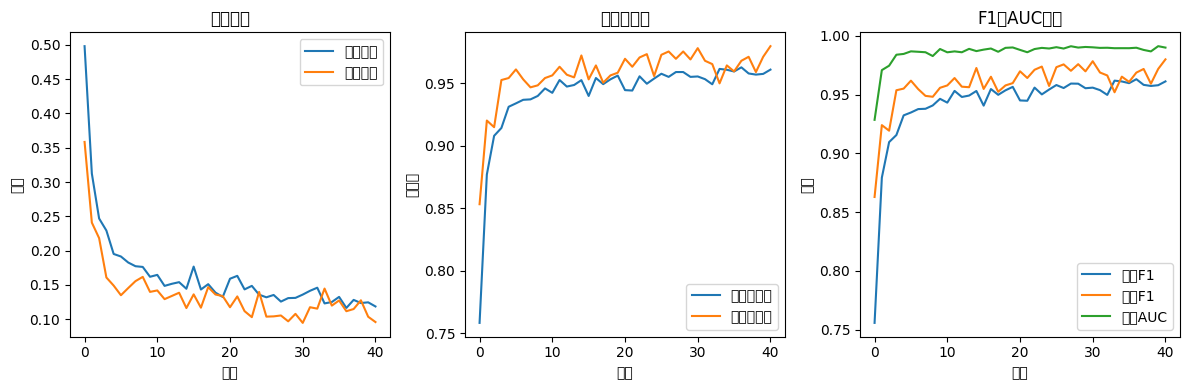

In [230]:
# 绘制训练曲线
import matplotlib.pyplot as plt
# 中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(12, 4))

# 损失曲线
plt.subplot(1, 3, 1)
plt.plot(history['train_loss'], label='训练损失')
plt.plot(history['val_loss'], label='验证损失')
plt.legend()
plt.title('损失曲线')
plt.xlabel('轮次')
plt.ylabel('损失')

# 准确率曲线
plt.subplot(1, 3, 2)
plt.plot(history['train_acc'], label='训练准确率')
plt.plot(history['val_acc'], label='验证准确率')
plt.legend()
plt.title('准确率曲线')
plt.xlabel('轮次')
plt.ylabel('准确率')

# F1和AUC曲线
plt.subplot(1, 3, 3)
plt.plot(history['train_f1'], label='训练F1')
plt.plot(history['val_f1'], label='验证F1')
plt.plot(history['val_auc'], label='验证AUC')
plt.legend()
plt.title('F1和AUC曲线')
plt.xlabel('轮次')
plt.ylabel('分数')

plt.tight_layout()
plt.show()



In [ ]:
# 加载最佳模型
model.load_state_dict(best_model)

# 在测试集上评估
test_loss, test_acc, test_prec, test_recall, test_f1, test_auc, test_bacc, test_aucpr = validate(model, test_loader, criterion)
print("\n最终测试结果:")
print(f"Loss: {test_loss:.4f}")
print(f"Accuracy: {test_acc:.4f}")
print(f"Precision: {test_prec:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")
print(f"AUC: {test_auc:.4f}")
print(f"BACC: {test_bacc:.4f}")
print(f"AUCPR: {test_aucpr:.4f}")


最终测试结果:
Loss: 0.0866
Accuracy: 0.9777
Precision: 0.9706
Recall: 0.9851
F1 Score: 0.9778
AUC: 0.9934
BACC: 0.9777
AUCPR: 0.9931
